# Practical work on graph-cut optimization (part 2, multilevel)

The objective of this PW is the implementation of the $\alpha$-expansion and $\alpha$-$\beta$ swap approaches for grayscale image denoising.

The PyMaxFlow library is used to compute the graph-cut.

In [2]:
import math
import random
import numpy as np
from numpy import log
#%matplotlib notebook
import matplotlib.pyplot as plt

import platform
import tempfile
import os
from scipy import ndimage as ndi
try:
    import maxflow
except:
    !pip install PyMaxflow  # For Google Collab
    import maxflow
from maxflow.fastmin import aexpansion_grid, abswap_grid

from skimage import io
import imageio.v2 as imageio
from skimage.morphology import binary_dilation, disk
from bokeh.plotting import figure, output_file, show
from bokeh.plotting import show as showbokeh
from bokeh.models.mappers import LogColorMapper, LinearColorMapper
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

## 2 Denoising a grayscale image


In this second part of the PW, we are interested in using Markovian methods to **denoise** images with different regularization potentials.

We are interested in denoising the images *Ibruitee.png* and *Ibruitee2.png* which correspond to the same scene perturbed by two noises of different nature.


We will complete programs that call the algorithm of alpha-expansions or Boykov's alpha-beta swap according to the Kolmogorov technique.


Q1: What are the respective expressions for the data attachment potentials in the case of noise following a Gaussian distribution (equation 1) and a Rayleigh distribution (equation 2)?

\begin{equation}
p(y_p|x_p)=\frac{1}{\sqrt{2\pi}\sigma}\exp\left[-\frac{(y_p-x_p)^2}{2\sigma^2}\right],
\end{equation}

\begin{equation}
p(y_p|x_p)=2\frac{y_p}{x_p^2}\exp\left[-\frac{y_p^2}{x_p^2}\right].
\end{equation}

**Your answer &#x270D;**

A1: 
On sait que le terme d'attache aux données est de la forme : $D(y_p \mid x_p) = -log(p(y_p \mid x_p))$

**Bruit gaussien** : 
$$D_{G}(y_p \mid x_p) = \frac{1}{2}log(2 \pi \sigma) + \frac{(y_p - x_p)^2}{2\sigma^2}$$

**Bruit de Rayleigh** : 
$$D_{R}(y_p \mid x_p) = - log(2) - log(y_p) + 2log(x_p) + \frac{y_p^2}{x_p^2}$$

Q2: By studying the histogram of a homogeneous area, indicate which type of noise is present in which image.  



**Your answer &#x270D;**

A2: D'aprèes les distributions des zones homogènes des 2 images on peut conclure que : 
- Pour l'image 1 le bruit est **Gaussien**
- Pour l'image 2 le bruit a une distribution de **Rayleigh**

(<Axes: title={'center': 'Noisy image 2'}>,
 Text(0.5, 1.0, 'Noisy image 2'))

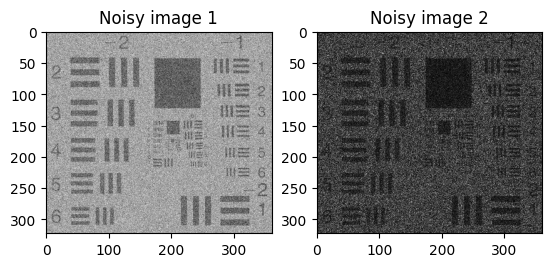

In [3]:
im_obs=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/Ibruitee.png').astype('float') # Observed image, noisy
im_obs2=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/Ibruitee2.png').astype('float') # Observed image, noisy
im_orig=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/IoriginaleBW.png').astype('float') # Reference binary image, to evaluate the quality of the segmentation

I = im_obs
plt.figure()
plt.subplot(1, 2, 1), plt.imshow(im_obs, vmin=0.0, vmax=255., cmap="grey"), plt.title("Noisy image 1")
plt.subplot(1, 2, 2), plt.imshow(im_obs2, vmin=0.0, vmax=255., cmap="grey"), plt.title("Noisy image 2")

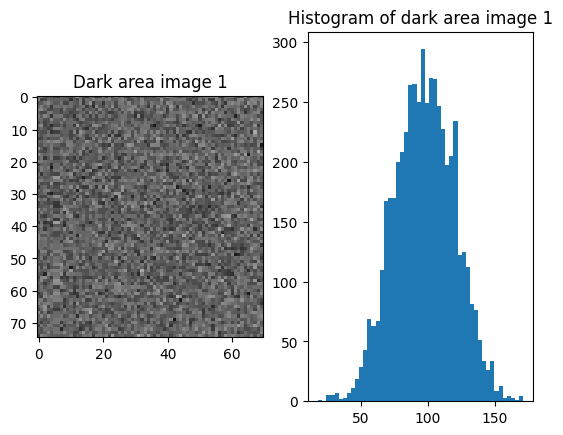

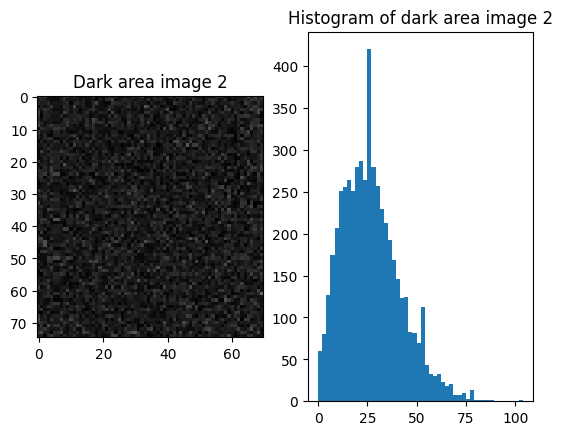

In [4]:
# select a homogeneous area to study the histogram
# we can use the area from 45 to 120 on vertical axis and from 175 to 245 on
# horizontal one
ymin, ymax, xmin, xmax = 45, 120, 175, 245

plt.figure()
plt.subplot(1, 2, 1), plt.imshow(im_obs[ymin:ymax, xmin:xmax], vmin=0.0, vmax=255., cmap="grey"), plt.title("Dark area image 1")
plt.subplot(1, 2, 2), plt.hist(im_obs[ymin:ymax, xmin:xmax].flatten(),50), plt.title("Histogram of dark area image 1")
plt.show()

plt.figure()
plt.subplot(1, 2, 1), plt.imshow(im_obs2[ymin:ymax, xmin:xmax], vmin=0.0, vmax=255., cmap="grey"), plt.title("Dark area image 2")
plt.subplot(1, 2, 2), plt.hist(im_obs2[ymin:ymax, xmin:xmax].flatten(),50), plt.title("Histogram of dark area image 2")
plt.show()



We will compare three *a priori* models: the Potts model $\delta_{x_p=x_q}$, the (discrete) total variation $|x_p-x_q|$, and the (quadratic) Gaussian model $(x_p-x_q)^2$.

Q3: Are they metrics or semi-metrics? What can we deduce about the optimization method to use?

**Your answer &#x270D;**

A3: On vérifie les propriétés pour chaque modèles :
Symétrie et Séparation pour les trois. 
- $\delta_{x_p = x_q}$ ne satisfait pas l'inégalité triangulaire, c'est donc une **semie-métrique**
- $\left|x_p - x_q\right|$ est évidemment une **métrique**
- $(x_p - x_q)^2$ ne satisfait pas l'inégalité triangulaire, c'est donc une **semie-métrique**

Q4: What are the differences between the $\alpha$-expansion method and the $\alpha$-$\beta$ swap method?

**Your answer &#x270D;**

A4: Pour le $\alpha - \beta$ swap on fait un graphe seulement avec les pixels du label $\alpha$ et $\beta$, puis on les fait choisir entre ces 2 labels. Il fonctionne avec des potentiels Semies-métriques. Alors que pour le $\alpha$-expension, on fait un graphe avec TOUS les pixels et on choisit si ces pixels prennent le label $\alpha$ ou non. Cela fonctionne uniquement avec des potentiels métriques

In the following sections we will use the functions **aexpansion_grid** and **abswap_grid** which perform the $\alpha$-expansion and $\alpha$-$\beta$ swap respectively. These functions take as input two arguments for a number of levels L :
- a tensor of the image size containing in the 3rd dimension the data attachment of each pixel for each considered level (unary term, $\texttt{D}$ in the following)
- a matrix containing the values of the interaction terms between two levels $l_1$ and $l_2$ (depends on the chosen interaction potential, $\texttt{V...}$ in the following)

### 2.1 Denoising in the Gaussian case (synthetic image)

Shape of D: (323, 361, 30)


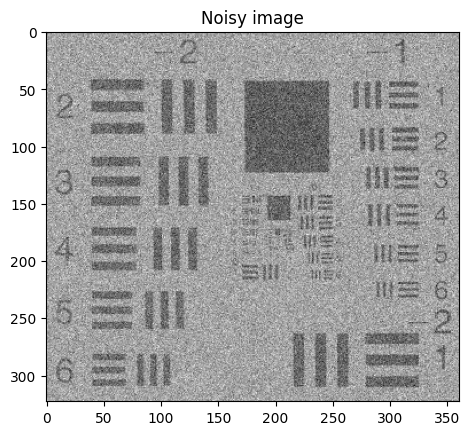

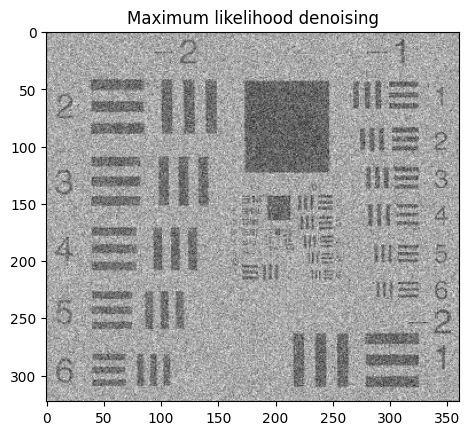

In [5]:
# Loading images
im_obs=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/Ibruitee.png').astype('float') # Observed image, noisy
im_orig=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/IoriginaleBW.png').astype('float') # Reference binary image, to evaluate the quality of the segmentation

I = im_obs

I = I*255/I.max()
L = 30
# Generates L gray levels for nearsest prototype labeling
levs = np.arange(1/L, 255, 255/L)
# Calculate data cost as the absolute difference between the label prototype and the pixel value
d = np.double(I.reshape(I.shape+(1,)) - levs.reshape((1,1,-1)))

D = d**2  # Complete to compute data attachment potential map from d

plt.figure()
plt.imshow(I, vmin=0.0, vmax=255., cmap="grey"), plt.title("Noisy image")

# Generate nearest prototype labeling
Id = np.argmin(D,2)
plt.figure()
plt.imshow(Id/(L-1)*255, vmin=0.0, vmax=255., cmap="grey"), plt.title("Maximum likelihood denoising")

print("Shape of D:", D.shape)


Q5: Here, what does the array $\texttt{d}$ correspond to? Explain its dimension.

From this array $\texttt{d}$, compute (in the code) the data attachment potential map $\texttt{D}$ for the considered noise.

**Your answer &#x270D;**

A5: d est l'array qui représente la différence entre les pixels de l'image observée et les "prototypes" de niveaux de gris `levs`. Les dimensions de d (height, width, L) corresponds à la taille de l'image et le nombre de niveau de gris (30).

Complete the programs below, and test each regularization model by determining an appropriate beta value each time and an appropriate multi-label graph-cut algorithm.

*Note:* in order to test several values of $\beta$, it is suggested to **crop your image** to 100x100 pixels for example.

(<matplotlib.image.AxesImage at 0x117c17410>,
 Text(0.5, 1.0, 'Graph Cut Denoising, Potts regularization, beta = 600'))

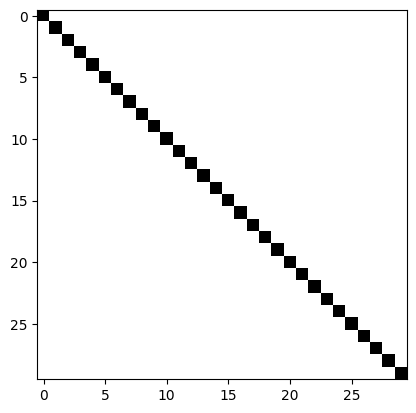

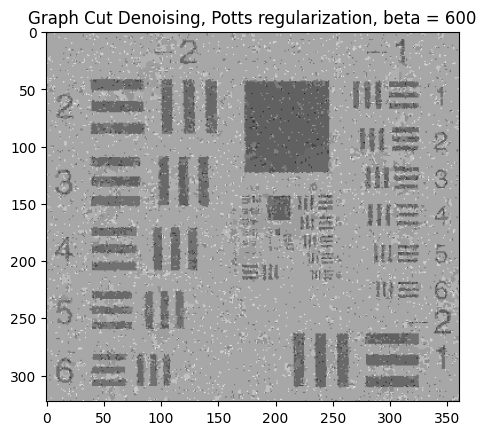

In [6]:
# Potts model regularization
# beta values of the order of hundreds/thousands
beta_Potts = 600

# definition of the regularization matrix V(i,j) for the Potts model

# HINT1
# Map of the difference between two classes (difference class to class):
d_c2c = levs.reshape((-1,1)) - levs.reshape((1,-1))
# If the regularization potential Vc(x1, x2) of a model is f(x1 - x2), then you
# must define : V_model = f(d_c2c)

# HINT2
# For Potts model, comparing two values is equivalent to compare to difference
# of these two values to some other value...

V_Potts =  beta_Potts* np.double(np.abs(d_c2c) > 0)
plt.figure()
plt.imshow(V_Potts, cmap="grey")

# Performs aexpansion_grid or abswap_grid based on the data attachment D and the regularization V
labels_Potts_swap = abswap_grid(np.double(D), V_Potts)
labels_Potts_expa = aexpansion_grid(np.double(D), V_Potts)
plt.figure()
plt.imshow(labels_Potts_swap/(L-1)*255, vmin=0.0, vmax=255.0, cmap="grey"), plt.title("Graph Cut Denoising, Potts regularization, beta = " + str(beta_Potts))

(<matplotlib.image.AxesImage at 0x117cfd0d0>,
 Text(0.5, 1.0, 'Graph Cut Denoising, TV regularization, beta = 20'))

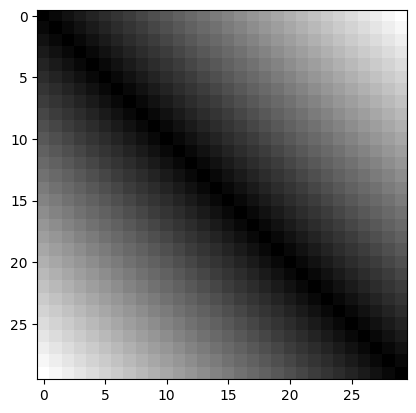

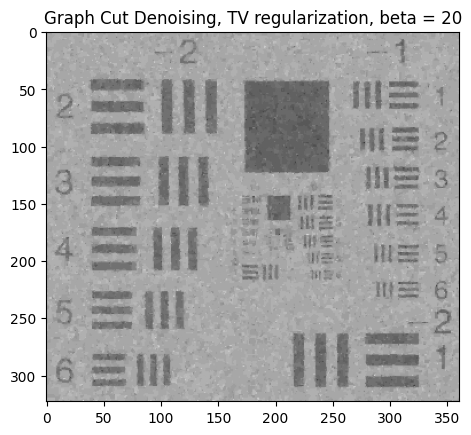

In [7]:
# TV model regularization
# beta value of the order of tens
beta_TV = 20

# definition of the regularization matrix V(i,j) for the TV model
V_TV = beta_TV * np.double(np.abs(d_c2c))
plt.figure()
plt.imshow(V_TV, cmap="grey")

# Performs aexpansion_grid or abswap_grid based on the data attachment D and the regularization V
labels_TV = aexpansion_grid(np.double(D), V_TV)
plt.figure()
plt.imshow(labels_TV/(L-1)*255, vmin=0.0, vmax=255.0, cmap="grey"), plt.title("Graph Cut Denoising, TV regularization, beta = " + str(beta_TV))

(<matplotlib.image.AxesImage at 0x116b69190>,
 Text(0.5, 1.0, 'Graph Cut Denoising, Quadratic regularization, beta = 1'))

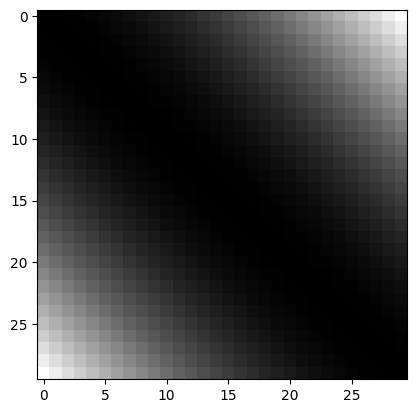

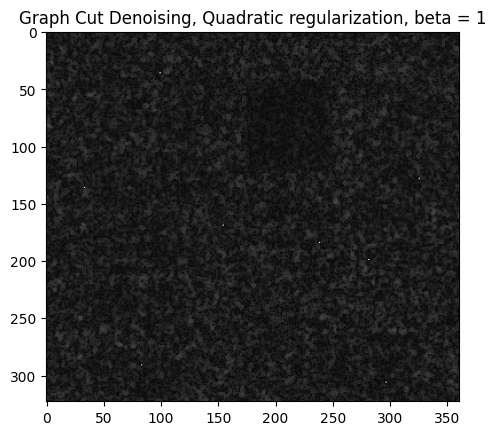

In [15]:
# Quadratic model regularization
# beta value of the order of tens
beta_quadratic = 1

# definition of the regularization matrix V(i,j) for the quadratic model
V_quadratic = beta_quadratic * np.double(d_c2c**2)
plt.figure()
plt.imshow(V_quadratic, cmap="grey")

# Performs aexpansion_grid or abswap_grid based on the data attachment D and the regularization V
labels_Quadratic = abswap_grid(np.double(D), V_quadratic)
plt.figure()
plt.imshow(labels_Quadratic/(L-1)*255, vmin=0.0, vmax=255.0, cmap="grey"), plt.title("Graph Cut Denoising, Quadratic regularization, beta = " + str(beta_quadratic))

Q6: Which regularization model do you think is best? Give the best regularization parameter visually found and comment on the results you get in each of the three cases.

**Your answer &#x270D;**

A6: Le modèle de potts semble être le meilleur car il enlève le bruit et préserve les contours de manière plutôt précise. Les autres retires bien le bruit mais l'image à la fin est un plus floue.

### 2.2 Denoising in the case of speckle noise (synthetic image)

Modify the following cells to fit the model for denoising the im_obs2 image.

Q7: Which modifications are needed? (There are several!)

**Your answer &#x270D;**

A7: Le bruit a une distribution de Rayleigh donc le terme d'attache aux données doit être modifié :  
 $$D = -log\left[2\frac{y_p}{x_p^2}\exp\left(-\frac{y_p^2}{x_p^2}\right)\right].$$

Ce qui va devoir être modifié aussi c'est les valeurs de $\beta$. En effet, avec un bruit de Rayleigh le terme n'est pas quadratique et produira une valeur de l'énergie beaucoup plus faible que pour un bruit gaussien. Pour que le $\beta$ est un impact il faut que sa valeur soit beaucoup plus basse.

/var/folders/fd/jm9_sr_d62nb781k94jfh0d00000gn/T/ipykernel_10592/1567318750.py:22: RuntimeWarning: divide by zero encountered in log
  D =  -np.log(2 * (ratio / levs.reshape((1,1,-1))) * np.exp(-ratio**2))


(<matplotlib.image.AxesImage at 0x134d39010>,
 Text(0.5, 1.0, 'Maximum likelihood denoising'))

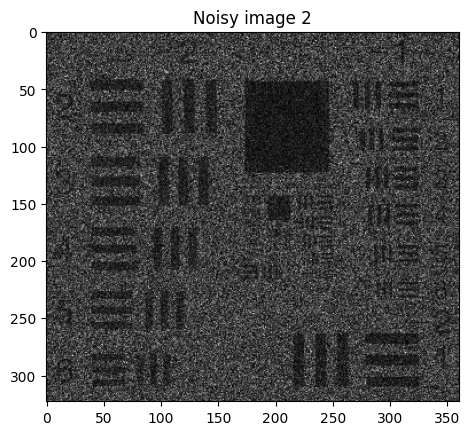

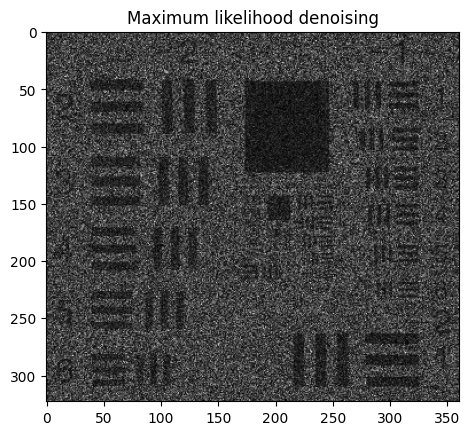

In [9]:
from maxflow.fastmin import aexpansion_grid
from numpy import log

# Loading image
im_obs2=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/Ibruitee2.png').astype('float') # Observed image, noisy
I = im_obs2
I = I*255/I.max()
plt.figure()
plt.imshow(I, vmin=0.0, vmax=255., cmap="grey"), plt.title("Noisy image 2")

L = 30
# Generates L gray levels for nearsest prototype labeling
levs = np.arange(1/L, 255, 255/L)

# Calculate data cost as the absolute difference between the label prototype and the pixel value

# HINT:
# The following computes the ratio between the data value and a class value for
# each class [ys / xs], and you can put a square on only one or on both terms.
ratio = I.reshape(I.shape+(1,)) / levs.reshape((1,1,-1))

D =  -np.log(2 * (ratio / levs.reshape((1,1,-1))) * np.exp(-ratio**2))
Id = np.argmin(D,2)

# Generate nearest prototype labeling
Id = np.argmin(D,2)
plt.figure()
plt.imshow(Id/(L-1)*255, vmin=0.0, vmax=255., cmap="grey"), plt.title("Maximum likelihood denoising")

(<matplotlib.image.AxesImage at 0x13786da50>,
 Text(0.5, 1.0, 'Graph Cut Denoising, Potts regularization, beta = 0.65'))

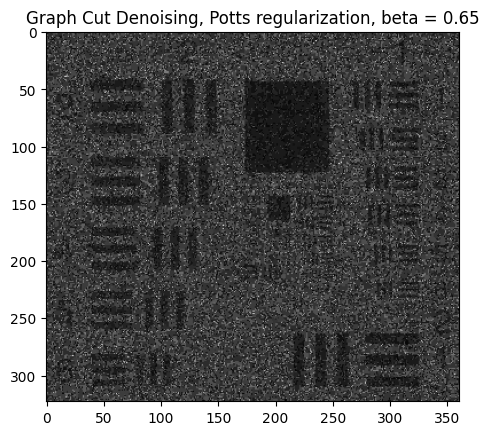

In [38]:
# beta value in the order of tenths of a unit
beta_Potts = 0.65
# definition of the Potts potential matrix
V_Potts = beta_Potts * np.double(np.abs(d_c2c) > 0)

# Performs aexpansion_grid or abswap_grid based on the data attachment D and the regularization V
labels_Potts =abswap_grid(np.double(D), V_Potts)
plt.figure()
plt.imshow(labels_Potts/(L-1)*255, vmin=0.0, vmax=255, cmap="grey"), plt.title("Graph Cut Denoising, Potts regularization, beta = " + str(beta_Potts))

(<matplotlib.image.AxesImage at 0x136f31210>,
 Text(0.5, 1.0, 'Graph Cut Denoising, TV regularization, beta = 0.017'))

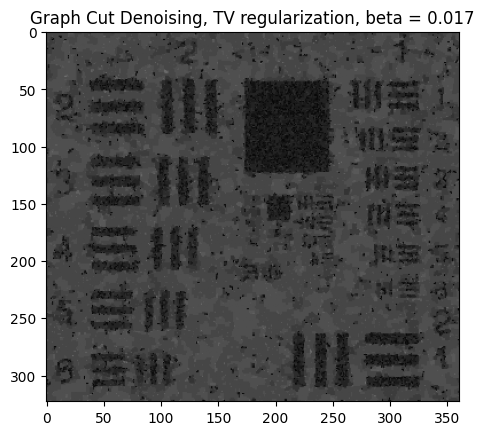

In [37]:
# beta value in hundredths of a unit
beta_TV = 0.017
# definition of the regularization matrix for TV
V_TV = beta_TV * np.double(np.abs(d_c2c))

# Performs aexpansion_grid or abswap_grid based on the data attachment D and the regularization V
labels_TV = aexpansion_grid(D, V_TV)
plt.figure()
plt.imshow(labels_TV/(L-1)*255, vmin=0.0, vmax=255, cmap="grey"), plt.title("Graph Cut Denoising, TV regularization, beta = " + str(beta_TV))

(<matplotlib.image.AxesImage at 0x137aa9910>,
 Text(0.5, 1.0, 'Graph Cut Denoising, Quadratic regularization, beta = 0.0009'))

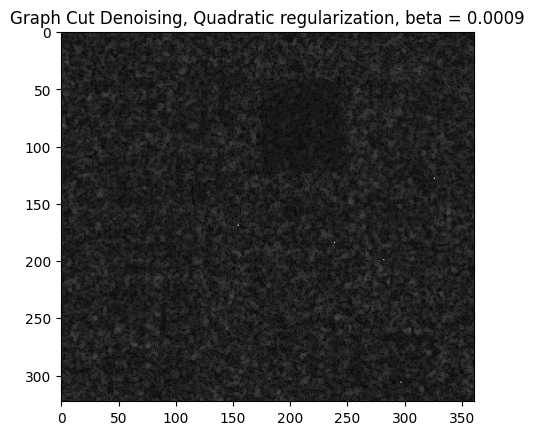

In [43]:
# beta value in the order of thousandths of a unit
beta_quadratic = 9e-4
# definition of the regularization matrix for a quadratic potential
V_quadratic = V_TV = beta_TV * np.double(d_c2c**2)

# Performs aexpansion_grid or abswap_grid based on the data attachment D and the regularization V
labels_Quadratic = abswap_grid(D, V_quadratic)
plt.figure()
plt.imshow(labels_Quadratic/(L-1)*255, vmin=0.0, vmax=255, cmap="grey"), plt.title("Graph Cut Denoising, Quadratic regularization, beta = " + str(beta_quadratic))

### 2.3 Denoising a natural image

Apply one of the methods used above to denoise the noisy cameraman image. Justify your choice.

*Note:* you should check how the noise is generated to choose your data attachment term.

Q8: Comment on the result obtained.

**Your answer &#x270D;**

A8:
Premièrement grace à la ligne ci-dessous, on peut dire que le bruit est Gaussien.
```python
I_cameraman_bruit = I_cameraman + np.random.normal(0,80,I_cameraman.shape)
```
Notre terme d'attache aux données va donc être celui d'une distrobution Gaussienne : $\frac{(y_p - x_p)^2}{2\sigma^2}$

Au vue du nombre de niveau de gris (250) il est préférable d'utiliser la méthode de variation totale pour pouvoir faire de $\alpha$-expansion. En effet, le $\alpha$-$\beta$ swap aura une plus grande complexité, et mettre donc plus de temps à s'exéxuter.  

On remarque avec le résultat que le bruit a bien réduit mais l'image est beaucoup plus floue. De plus, dans les zones homogènes le résultat est moins convaincant.


(<matplotlib.image.AxesImage at 0x138fb5810>, Text(0.5, 1.0, 'Noisy image'))

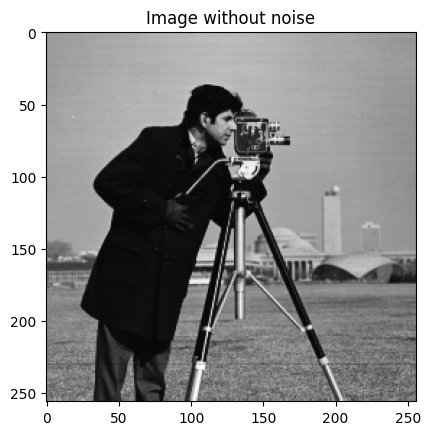

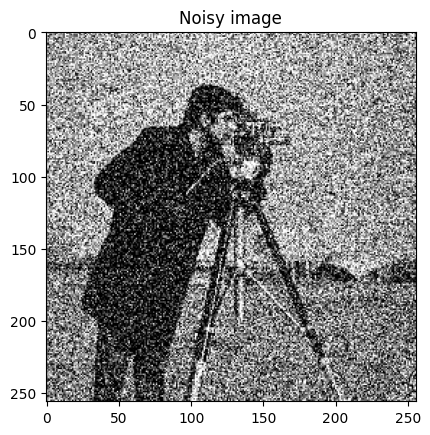

In [55]:
I_cameraman = imageio.imread('https://people.math.sc.edu/Burkardt/data/tif/cameraman.tif')
I_cameraman_bruit = I_cameraman + np.random.normal(0,80,I_cameraman.shape)
I_cameraman_bruit[I_cameraman_bruit<0] = 0
I_cameraman_bruit[I_cameraman_bruit>255] = 255

plt.figure()
plt.imshow(I_cameraman, vmin=0.0, vmax=255, cmap="grey"), plt.title("Image without noise")
plt.figure()
plt.imshow(I_cameraman_bruit, vmin=0.0, vmax=255, cmap="grey"), plt.title("Noisy image")

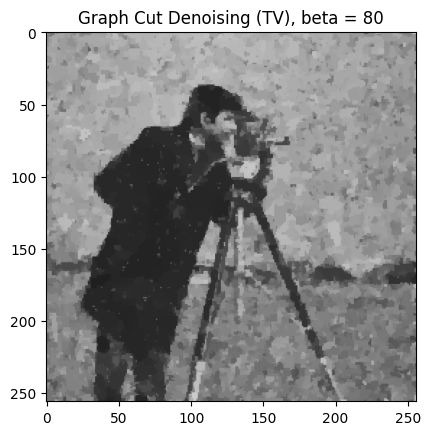

In [54]:
I = 255*I_cameraman_bruit/I_cameraman_bruit.max()
L = 250
# Generates L gray levels for nearsest prototype labeling
levs = np.arange(1/L, 255, 255/L)
# Calculate data cost as the absolute difference between the label prototype and the pixel value
d = np.double(I.reshape(I.shape+(1,)) - levs.reshape((1,1,-1)))
D = d**2
d_c2c = levs.reshape((-1,1)) - levs.reshape((1,-1))
# choose a regularization model and compute V matrix
# compute the appropriate optimization
# TV regularization (meilleur pour images naturelles)
beta_TV = 80
V_TV = beta_TV * np.double(np.abs(d_c2c))

# Compute the appropriate optimization (TV est une métrique -> aexpansion)
labels_TV = aexpansion_grid(np.double(D), V_TV)

# Display the regularized image
plt.figure()
plt.imshow(labels_TV/(L-1)*255, vmin=0.0, vmax=255, cmap="grey")
plt.title("Graph Cut Denoising (TV), beta = " + str(beta_TV))
plt.show()


### 2.3 SAR Image Denoising

SAR (Synthetic Aperture Radar) imagery is a radar-based remote sensing modality that provides images of the Earth in all light and weather conditions. A major drawback is the high speckle noise that affects them. The following cell loads an amplitude image acquired by the Sentinel 1-A satellite over the city of Des Moines in the USA. To limit the computation time, we will work on a small rectangle from the image provided.

Adapt one of the methods used previously to denoise the image provided. We will assume that the noise follows a Rayleigh distribution.

Q9: Comment on the result obtained.

We can compare the result with a denoising obtained by a more recent method (SAR2SAR), based on a Deep Learning approach (the code to display it is provided below).

**Your answer &#x270D;**

A9: On remarque que le bruit sur le résultat obtenue a été fortement diminué. Cependant on a perdu énormément de détail surtout par rapport à la méthode SAR2SAR, basée sur du deep learning. 

--2026-01-16 15:46:22--  https://www.dropbox.com/s/7m2dw3irho8dpzj/noisy_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1
Résolution de www.dropbox.com (www.dropbox.com)… 2620:100:6023:18::a27d:4312, 162.125.67.18
Connexion à www.dropbox.com (www.dropbox.com)|2620:100:6023:18::a27d:4312|:443… connecté.
requête HTTP transmise, en attente de la réponse… 302 Found
Emplacement : https://www.dropbox.com/scl/fi/jwvyealp7dqh18bq8q6tu/noisy_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?rlkey=std8m4v6jdnqt5vlvma8k28i2&dl=1 [suivant]
--2026-01-16 15:46:22--  https://www.dropbox.com/scl/fi/jwvyealp7dqh18bq8q6tu/noisy_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?rlkey=std8m4v6jdnqt5vlvma8k28i2&dl=1
Réutilisation de la connexion existante à [www.dropbox.com]:443.
requête HTTP transmise, en attente de la réponse… 302 Found
Emplacement : https://ucbf6781bd002fc1c37f74c0d25a.dl.dropboxusercontent.com/cd/0/inline/C5G3oQfCUnSbS-QLUCK_nGvEzs2ykZsV8RctqFt-HKK0wqCsStYGQ0RQMGNnO8vAwFAKrAbNm5GyQXcpxLpIrgiME8b61

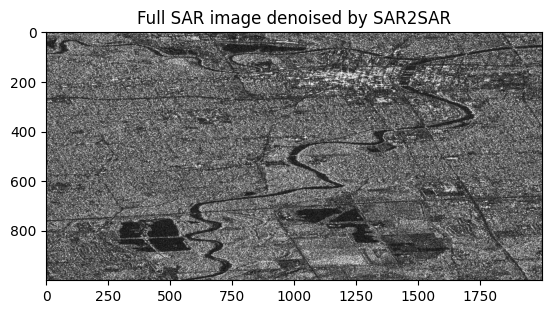

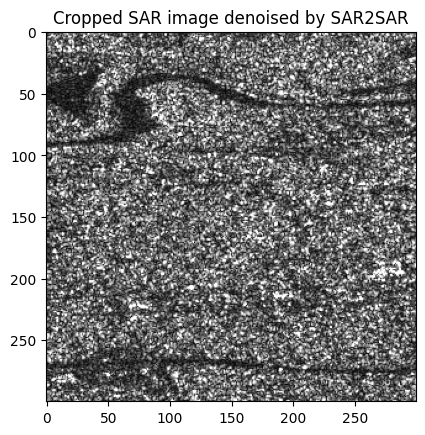

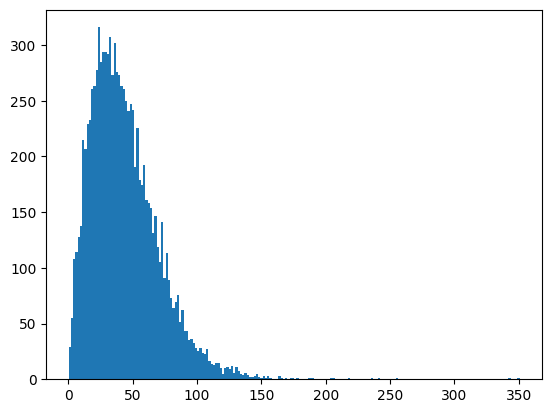

In [56]:
try:
    I_SAR = np.load('noisy_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1')
except:
    !wget 'https://www.dropbox.com/s/7m2dw3irho8dpzj/noisy_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1'
    I_SAR = np.load('noisy_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1')

plt.figure()
plt.imshow(I_SAR, vmin=0.0, vmax=100, cmap="grey"), plt.title("Full SAR image denoised by SAR2SAR")
plt.figure()
plt.imshow(I_SAR[0:300,0:300], vmin=0.0, vmax=100, cmap="grey"), plt.title("Cropped SAR image denoised by SAR2SAR")

I_SAR = I_SAR[0:300,0:300]
plt.figure()
plt.hist(I_SAR[100:200,100:200].flatten(),200) # Display of the histogram on an almost homogeneous area
plt.show()

/var/folders/fd/jm9_sr_d62nb781k94jfh0d00000gn/T/ipykernel_10592/687513000.py:9: RuntimeWarning: divide by zero encountered in log
  D = -np.log(2 * (ratio / levs.reshape((1,1,-1))) * np.exp(-ratio**2))


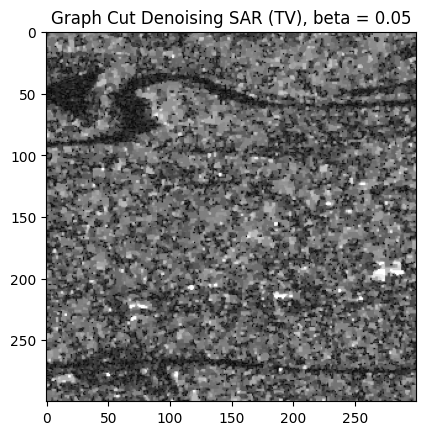

In [ ]:
I = I_SAR*255/I_SAR.max()
L = 255

# Generates L gray levels for nearest prototype labeling
levs = np.arange(1/L, 255, 255/L)

# Calculate data cost as the neg-log likelihood
ratio = I.reshape(I.shape+(1,)) / levs.reshape((1,1,-1))
D = -np.log(2 * (ratio / levs.reshape((1,1,-1))) * np.exp(-ratio**2))

# choose a regularization model and compute V matrix
d_c2c = levs.reshape((-1,1)) - levs.reshape((1,-1))
beta_TV = 0.02
V_TV = beta_TV * np.double(np.abs(d_c2c))

# compute the appropriate optimization
labels = aexpansion_grid(np.double(D), V_TV)

# display the regularized image: you must invert previous grayscale dynamic transformations.
denoised = (labels / (L-1)) * I_SAR.max()
plt.figure()
plt.imshow(denoised, vmin=0.0, vmax=100, cmap="grey")
plt.title("Graph Cut Denoising SAR (TV), beta = " + str(beta_TV))
plt.show()

--2026-01-16 15:53:28--  https://www.dropbox.com/s/0f6l0qr6teck5bd/denoised_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1
Résolution de www.dropbox.com (www.dropbox.com)… 2620:100:6023:18::a27d:4312, 162.125.67.18
Connexion à www.dropbox.com (www.dropbox.com)|2620:100:6023:18::a27d:4312|:443… connecté.
requête HTTP transmise, en attente de la réponse… 302 Found
Emplacement : https://www.dropbox.com/scl/fi/36hovwoq4va9xf4c5etes/denoised_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?rlkey=re3g3e5y9lzg8w8fxd24i42jq&dl=1 [suivant]
--2026-01-16 15:53:29--  https://www.dropbox.com/scl/fi/36hovwoq4va9xf4c5etes/denoised_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?rlkey=re3g3e5y9lzg8w8fxd24i42jq&dl=1
Réutilisation de la connexion existante à [www.dropbox.com]:443.
requête HTTP transmise, en attente de la réponse… 302 Found
Emplacement : https://uc8ac7a13247863b8ef2e5b84257.dl.dropboxusercontent.com/cd/0/inline/C5HeX1C4R4WspUCwKeo_1qQBJzS6-3E5jObHOftx-VtM3cGSHZQ8WziSEZyZPVZUdfA2Bdg8Sxd0hK8jOi1Z

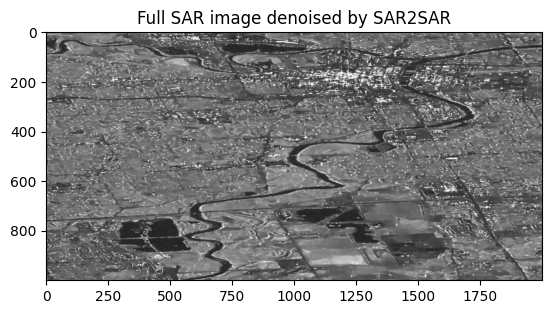

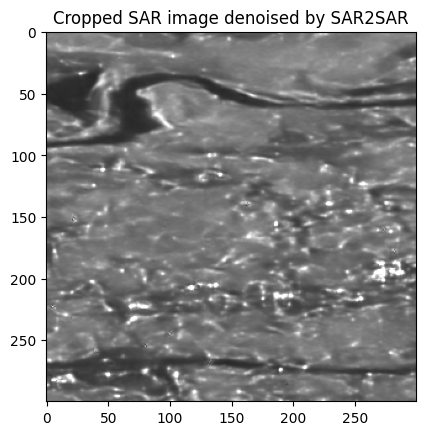

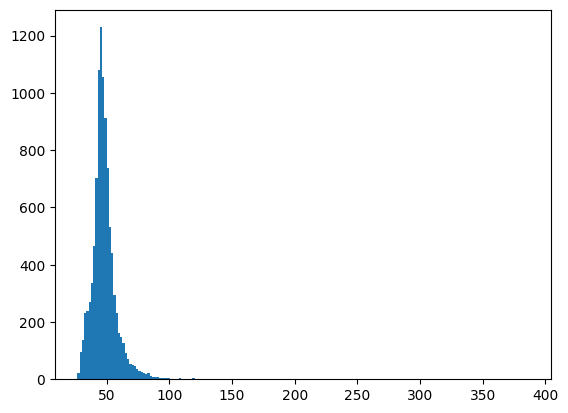

In [60]:
# Display of the denoised image by the SAR2SAR method

try:
    denoised_I_SAR = np.load('denoised_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1')
except:
    !wget 'https://www.dropbox.com/s/0f6l0qr6teck5bd/denoised_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1'
    denoised_I_SAR = np.load('denoised_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1')

plt.figure()
plt.imshow(denoised_I_SAR, vmin=0.0, vmax=100, cmap="grey"), plt.title("Full SAR image denoised by SAR2SAR")
plt.figure()
plt.imshow(denoised_I_SAR[0:300,0:300], vmin=0.0, vmax=100, cmap="grey"), plt.title("Cropped SAR image denoised by SAR2SAR")

plt.figure()
plt.hist(denoised_I_SAR[100:200,100:200].flatten(), 200) # Display of the histogram on an almost homogeneous area
plt.show()